# Statistical analysis of GoFast scooter rental service data

**Project goal: process user, ride, and subscription data and perform statistical analysis and hypothesis testing. The marketing department will use the results for campaigns.**

**Work plan:**
1. Load data
1. Data preprocessing: find duplicates, missing values, and fix data types
1. Exploratory data analysis, visualization, and dataset description
1. Merge data into a single table, split by subscription type
1. Calculate monthly revenue from users
1. Test hypotheses proposed by app managers
1. Build distributions for the marketing department
    

**Data description:**

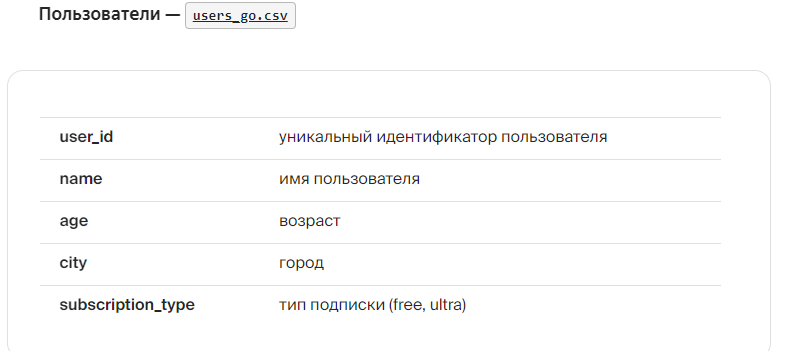

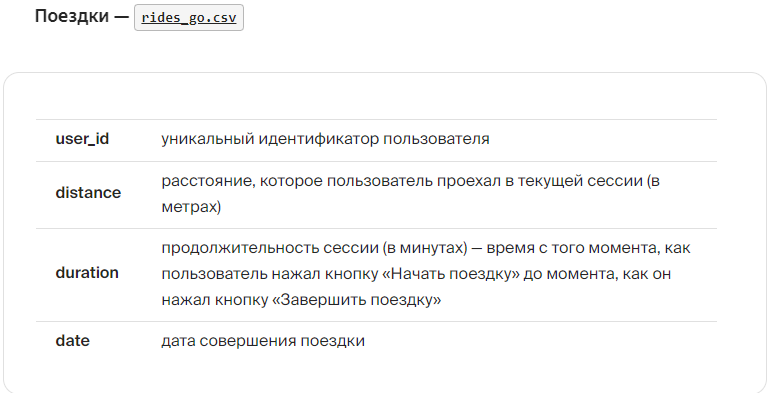

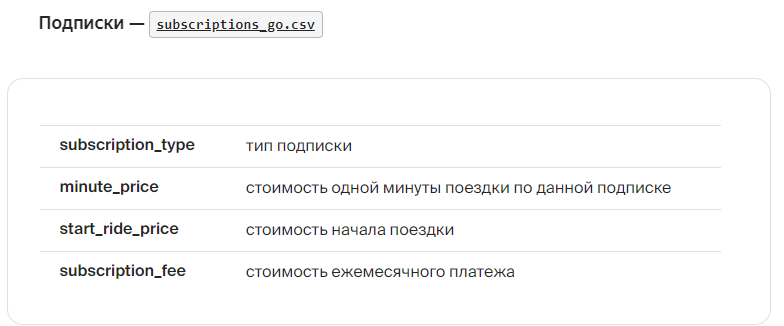

In [127]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from math import sqrt

#### Step 1. Data loading

##### users_go

In [129]:
users_df = pd.read_csv('users_go.csv')
users_df.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [130]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


*The table contains 1565 records, user id and age are integers, all other variables are strings. Data types do not need to be changed.*

In [131]:
users_df['user_id'].nunique()

1534

In [132]:
dupl_user_ids = users_df['user_id'].value_counts() > 1
dupl_user_ids = dupl_user_ids[dupl_user_ids].index
dupl_user_ids

Index([ 209,  807,  611,   43,  737,   47, 1198,  829,  924,  153,  635,   72,
        909,  908,  136, 1045, 1237,  127,  659,  307, 1245,  121,  666,  108,
        297,  809,  293,   16,  422,  403,  204],
      dtype='int64', name='user_id')

In [133]:
users_df[users_df['user_id'].isin(dupl_user_ids)].sort_values(by='user_id')

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
1539,43,Стефания,22,Омск,ultra
1563,47,Юрий,28,Тюмень,ultra
...,...,...,...,...,...
1554,1198,Демид,29,Ростов-на-Дону,free
1558,1237,Евгения,23,Тюмень,free
1236,1237,Евгения,23,Тюмень,free
1544,1245,Регина,27,Пятигорск,free


**Duplicate ids are exact duplicates**

##### rides_go

In [134]:
rides_df = pd.read_csv('rides_go.csv', parse_dates=['date'])
rides_df.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [135]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


*The table contains 18068 records, user ids are integers, distance and duration are floats. Data types do not need to be changed.*

In [136]:
rides_df['user_id'].nunique()

1534

*The number of unique ids matches*

##### subscriptions_go

In [137]:
subscriptions_df = pd.read_csv('subscriptions_go.csv')
subscriptions_df.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


 **When loading and first viewing the data, we found exact duplicates in users_df, and converted the date column in rides_df to datetime.**

#### Step 2. Data preprocessing

##### Month column

In [138]:
rides_df['month'] = rides_df['date'].dt.month
rides_df.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [139]:
rides_df['date'].min()

Timestamp('2021-01-01 00:00:00')

In [140]:
rides_df['date'].max()

Timestamp('2021-12-30 00:00:00')

##### Handling missing values

In [141]:
list(map((lambda x: x.isna().sum()), [users_df, rides_df]))

[user_id              0
 name                 0
 age                  0
 city                 0
 subscription_type    0
 dtype: int64,
 user_id     0
 distance    0
 duration    0
 date        0
 month       0
 dtype: int64]

**No missing values found**

##### Handling duplicates

In [142]:
users_df.duplicated().sum()

31

In [143]:
users_df = users_df.drop_duplicates().reset_index(drop=True)

In [144]:
rides_df.duplicated().sum() #no exact duplicates found

0

#### Step 3. Exploratory data analysis

##### City frequency

In [145]:
users_df['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

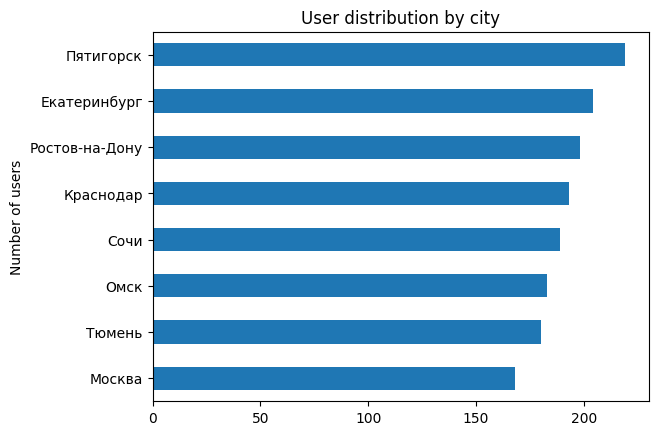

In [146]:

users_df.groupby('city')['city'].count().sort_values(ascending=True).plot(
    kind='barh',
    ylabel='Number of users',
    title='User distribution by city'
)
print()

**Users are distributed fairly evenly across cities, with the fewest in Moscow and the most in Pyatigorsk**

##### Ratio of users with and without subscription

In [147]:
users_df['subscription_type'].value_counts()

subscription_type
free     835
ultra    699
Name: count, dtype: int64

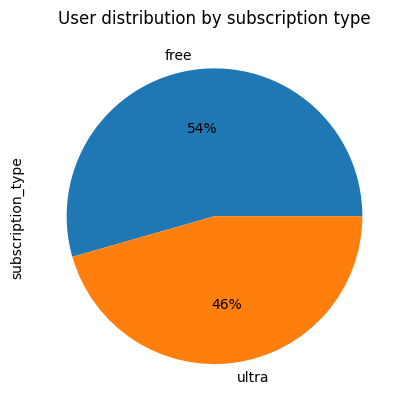

In [148]:
users_df.groupby('subscription_type')['subscription_type'].count().sort_values(ascending=False).plot(
    kind='pie',
    title='User distribution by subscription type',
    autopct='%1.0f%%'
)
print()

**There are 8% more users without a paid subscription than with one.**

##### User age

In [149]:
users_df['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

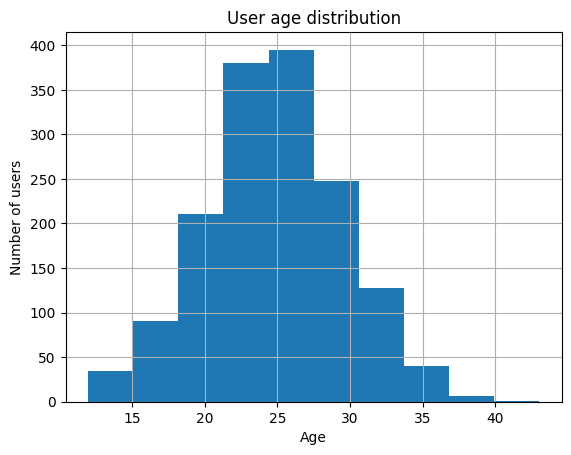

In [150]:
plt.xlabel('Age')
plt.ylabel('Number of users')
plt.title('User age distribution')
users_df['age'].hist(bins=10)
print()

**The app is used by people aged 12 to 43, with a mean and median of about 25 years.**

##### Distance traveled per ride

In [151]:
rides_df['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [152]:
rides_df.query('distance < 30 and duration > 10').sort_values(by='distance')

,user_id,distance,duration,date,month
11555,1069,0.855683,10.001902,2021-01-31,1
7841,796,7.097072,10.026614,2021-11-26,11
13940,1240,15.000606,10.045002,2021-08-20,8
11862,1091,15.630873,13.044660,2021-03-29,3
6611,707,28.793204,14.143966,2021-09-12,9


<Axes: title={'center': 'Ride distance boxplot'}>

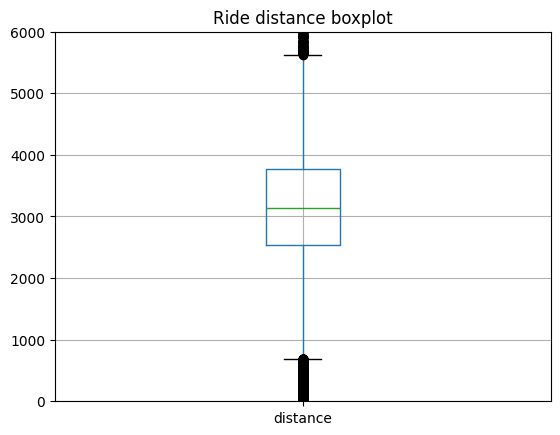

In [153]:
plt.title('Ride distance boxplot')
plt.ylim(0, 6000)
rides_df.boxplot(column='distance')

**It does not make sense to remove very small/large ride distances in this study, as users may have forgotten/waited to end the ride in the app, resulting in long times for short distances. Long rides are also possible, and the maximum of 7211 meters is reasonable.**

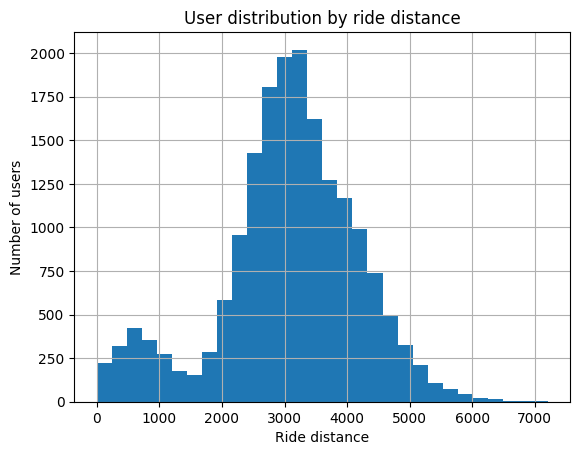

In [154]:
plt.xlabel('Ride distance')
plt.ylabel('Number of users')
plt.title('User distribution by ride distance')
rides_df['distance'].hist(bins=30)
print()

**The distribution peaks around 500 meters, as scooters are often used for short trips, e.g., to the subway/store nearby. There is also a peak around 3100 meters, matching the median of 3133 meters.**

##### Ride duration

In [155]:
rides_df['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [156]:
rides_df.query('duration < 1').sort_values(by='duration')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
14615,1287,5944.789947,0.5,2021-12-09,12
14574,1285,6316.574814,0.5,2021-09-25,9
14417,1273,4178.876258,0.5,2021-04-30,4
14342,1268,4177.139336,0.5,2021-06-09,6
...,...,...,...,...,...
9581,928,4857.412920,0.5,2021-06-06,6
9497,922,4620.899239,0.5,2021-01-05,1
9282,907,4520.123807,0.5,2021-04-24,4
10426,987,5375.139265,0.5,2021-03-16,3


In [157]:
rides_df.query('duration < 1')['distance'].describe()

count      95.000000
mean     5113.176549
std       658.254104
min      4030.308008
25%      4611.510820
50%      5052.769411
75%      5488.459099
max      7211.007745
Name: distance, dtype: float64

**Very fast rides (less than a minute) have abnormally large distances: from 4030 to 7211 meters. There are 95 such anomalies.**

**These are obvious outliers/app errors, all durations are 0.5 minutes with distances over 4km. We will drop these and notify the app team.**

In [158]:
rides_df = rides_df[rides_df['duration'] >= 1]
rides_df['duration'].describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

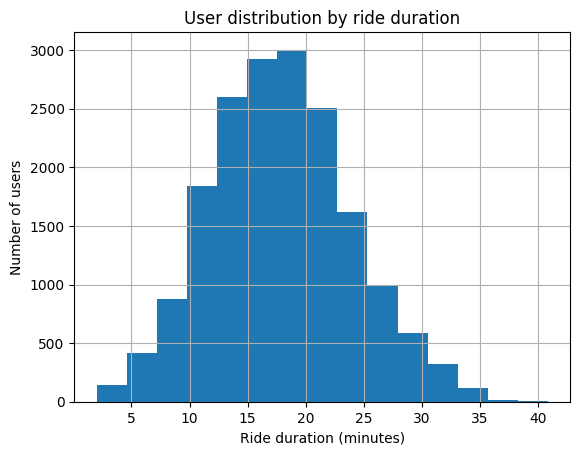

In [159]:
plt.xlabel('Ride duration (minutes)')
plt.ylabel('Number of users')
plt.title('User distribution by ride duration')
rides_df['duration'].hist(bins=15)
print()

**The distribution is close to normal and peaks at 18 minutes.**

#### Step 4. Data merging

##### Merging the three original datasets into one

In [160]:
rides_df.shape[0]

17973

**The original table to which we merged others has 17937 rows**

In [161]:
df = rides_df.merge(users_df, on='user_id')
df = df.merge(subscriptions_df, on='subscription_type')
df

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
17969,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
17970,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
17971,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


In [162]:
df.shape[0]

17973

**The merged table has the same number of rows as the original**

In [163]:
df.isna().any()

user_id              False
distance             False
duration             False
date                 False
month                False
name                 False
age                  False
city                 False
subscription_type    False
minute_price         False
start_ride_price     False
subscription_fee     False
dtype: bool

**There are no missing values in the merged table, merge was successful**

##### Splitting data by subscription type

In [164]:
df['subscription_type'].value_counts()

subscription_type
free     11473
ultra     6500
Name: count, dtype: int64

In [165]:
df_ultra = df.query('subscription_type == "ultra"')
df_ultra.shape[0]

6500

In [166]:
df_free = df.query('subscription_type == "free"')
df_free.shape[0]

11473

**Sample sizes match, splitting is correct.**

##### Visualizing ride distance and duration for both user categories

###### Distance

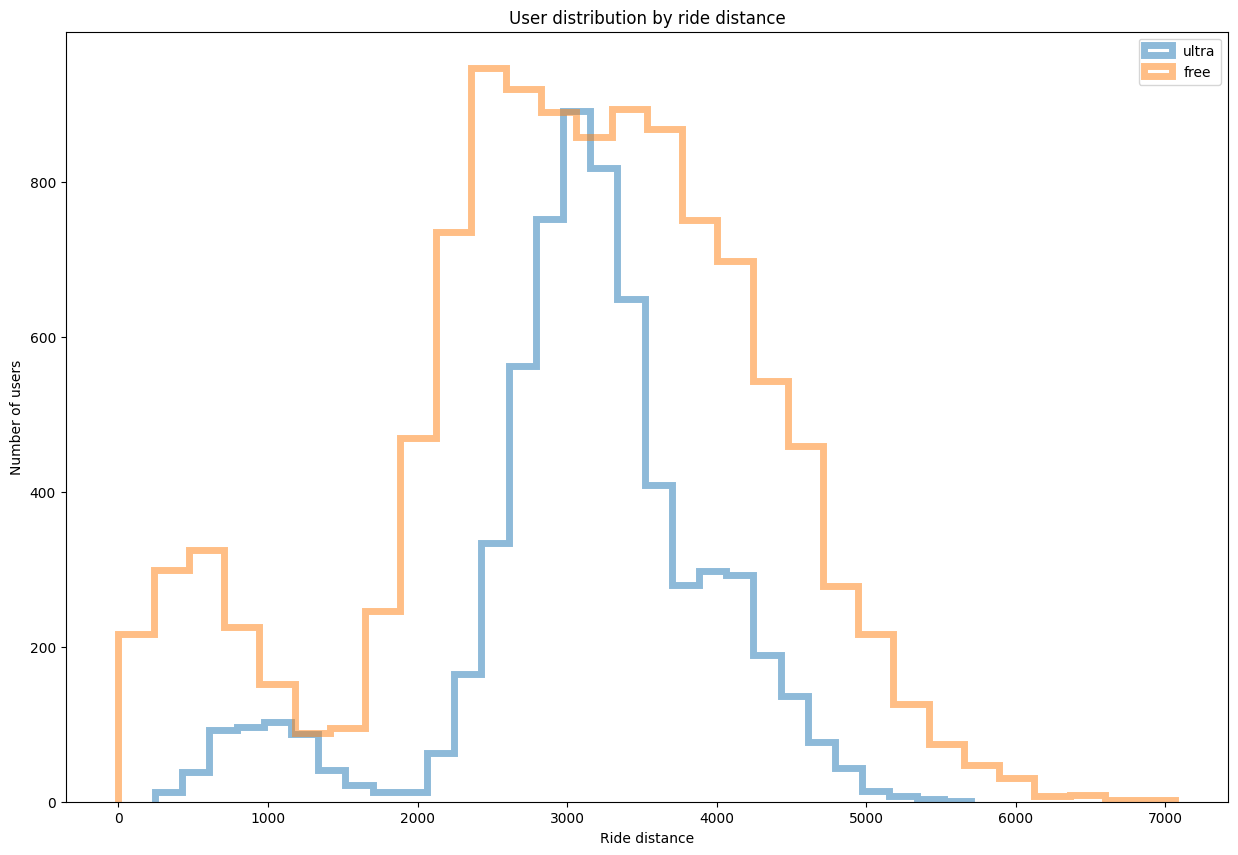

In [167]:
plt.figure(figsize=(15,10))
plt.xlabel('Ride distance')
plt.ylabel('Number of users')
plt.title('User distribution by ride distance')
plt.hist(
    df_ultra['distance'],
    bins=30,
    alpha=0.5,
    label='ultra',
    histtype='step',
    linewidth=5,
)
plt.hist(
    df_free['distance'],
    bins=30,
    alpha=0.5,
    label='free',
    histtype='step',
    linewidth=5
)
plt.legend(loc='upper right')
plt.show()

In [168]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [169]:
df_free['distance'].describe()

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

**The median ride distance is higher for subscribers (3148 > 3102), and the mean is also higher (3115 > 3028). The minimum ride distance for a subscriber is 244 meters, for a non-subscriber 0.86 meters. The maximum for subscribers is 5699 meters, for non-subscribers 7066 meters.**

In [170]:
st.percentileofscore(df_free['distance'], 500)

4.767715505970539

In [171]:
st.percentileofscore(df_ultra['distance'], 500)

0.23076923076923078

**Short rides under 500 meters make up only 0.23% of all rides for subscribers, while for non-subscribers they make up 4.77%.**

**The distribution peak for both paid and free subscriptions is between 2500 and 3500 meters, with more spread for free subscriptions.**

###### Ride duration

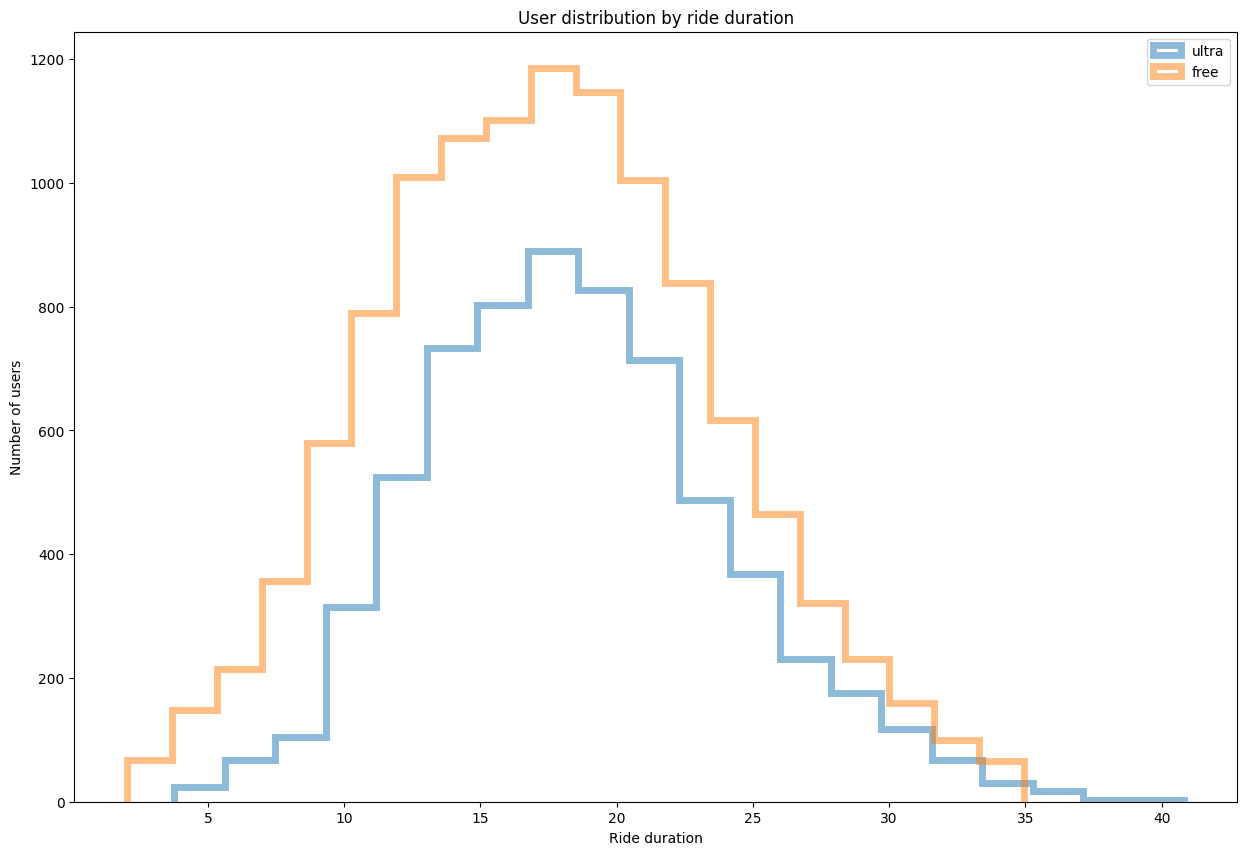

In [172]:
plt.figure(figsize=(15,10))
plt.xlabel('Ride duration')
plt.ylabel('Number of users')
plt.title('User distribution by ride duration')
plt.hist(
    df_ultra['duration'],
    bins=20,
    alpha=0.5,
    label='ultra',
    histtype='step',
    linewidth=5,
)
plt.hist(
    df_free['duration'],
    bins=20,
    alpha=0.5,
    label='free',
    histtype='step',
    linewidth=5
)
plt.legend(loc='upper right')
plt.show()

**The peaks for both paid and free subscriptions are around 18 minutes.**

#### Step 5. Revenue calculation

##### Create aggregated dataframe

In [173]:
df['duration_ceil'] = np.ceil(df['duration'])
df_agg = df.pivot_table(
    index=['user_id', 'month', 'subscription_type'],
    values=['distance', 'duration_ceil'],
    aggfunc={'distance': ['sum','count'],'duration_ceil': 'sum'}
)
df_agg.columns = ['count', 'distance_sum', 'duration_sum']
df_agg = df_agg.reset_index()
df_agg = df_agg.merge(subscriptions_df, on='subscription_type')
df_agg

,user_id,month,subscription_type,count,distance_sum,duration_sum,minute_price,start_ride_price,subscription_fee
0,1,1,ultra,2,7027.511294,42.0,6,0,199
1,1,4,ultra,1,754.159807,7.0,6,0,199
2,1,8,ultra,2,6723.470560,46.0,6,0,199
3,1,10,ultra,2,5809.911100,32.0,6,0,199
4,1,11,ultra,3,7003.499363,56.0,6,0,199
...,...,...,...,...,...,...,...,...,...
11295,1534,6,free,2,3409.468534,26.0,8,50,0
11296,1534,8,free,2,7622.453034,48.0,8,50,0
11297,1534,9,free,1,4928.173852,23.0,8,50,0
11298,1534,11,free,4,13350.015305,78.0,8,50,0


##### Add monthly revenue

In [174]:
def month_revenue(row):
        return (row['subscription_fee'] + row['start_ride_price'] * row['count'] + row['duration_sum'] * row['minute_price'])

In [175]:
df_agg['month_revenue'] = df_agg.apply(month_revenue, axis=1)
df_agg

,user_id,month,subscription_type,count,distance_sum,duration_sum,minute_price,start_ride_price,subscription_fee,month_revenue
0,1,1,ultra,2,7027.511294,42.0,6,0,199,451.0
1,1,4,ultra,1,754.159807,7.0,6,0,199,241.0
2,1,8,ultra,2,6723.470560,46.0,6,0,199,475.0
3,1,10,ultra,2,5809.911100,32.0,6,0,199,391.0
4,1,11,ultra,3,7003.499363,56.0,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...
11295,1534,6,free,2,3409.468534,26.0,8,50,0,308.0
11296,1534,8,free,2,7622.453034,48.0,8,50,0,484.0
11297,1534,9,free,1,4928.173852,23.0,8,50,0,234.0
11298,1534,11,free,4,13350.015305,78.0,8,50,0,824.0


*To check, let's manually calculate the value for user_id == 1 and the first month: the user has an ultra subscription, 2 rides, and a total ride time of 42 minutes (rounded up). Calculation: 199 + (6 * 42) = 451 RUB. The value matches the table.*

#### Step 6. Hypothesis testing

##### Do subscribers spend more time on rides than non-subscribers?

**We take session duration data from the split datasets and perform a two-sample t-test for independent samples. The null hypothesis (H0) is that the true means of the two populations (with and without subscription) are equal, and the alternative (H1) is that the mean for Ultra subscribers is greater than for Free users (right-sided test).**

**In this hypothesis, we compare the mean ride time for subscribers and non-subscribers.**

In [176]:
#df_ultra_sample = df_ultra['duration'].sample(n=3000, random_state=1)
#df_free_sample = df_free['duration'].sample(n=3000, random_state=1)

In [177]:
alpha = 0.05# set significance level to 5%
results = st.ttest_ind(df_ultra['duration'], df_free['duration'], alternative='greater') #two-sample t-test for independent samples
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-value: 4.7044680744539e-28
Reject the null hypothesis


**We reject the null hypothesis in favor of the alternative: the mean ride duration for Ultra subscribers is greater than for Free users.**

##### Is the mean distance traveled per ride by subscribers no more than 3130 meters?

**Null hypothesis (H0): the true mean ride distance for subscribers is 3130 meters. The alternative (H1): the true mean is greater than 3130 meters (right-sided test). We use a one-sample t-test.**

In [178]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [179]:
interested_value = 3130
alpha = 0.05# set significance level to 5%
results = st.ttest_1samp(df_ultra['distance'], interested_value, alternative='greater') #one-sample t-test
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-value: 0.9195368847849785
Failed to reject the null hypothesis


**We cannot reject the null hypothesis, as the observed mean is close to the hypothesized value. The optimal distance value is overestimated, as the probability of getting the observed mean or higher is 91.9%.**

##### Is the monthly revenue from subscribers higher than from non-subscribers?

**Here we compare the mean monthly revenue from subscribers and non-subscribers. We use a two-sample t-test for independent samples. The null hypothesis (H0) is that the true means are equal, the alternative (H1) is that the mean for Ultra subscribers is greater (right-sided test).**

**First, let's visualize the monthly revenue distributions and analyze the standard deviation.**

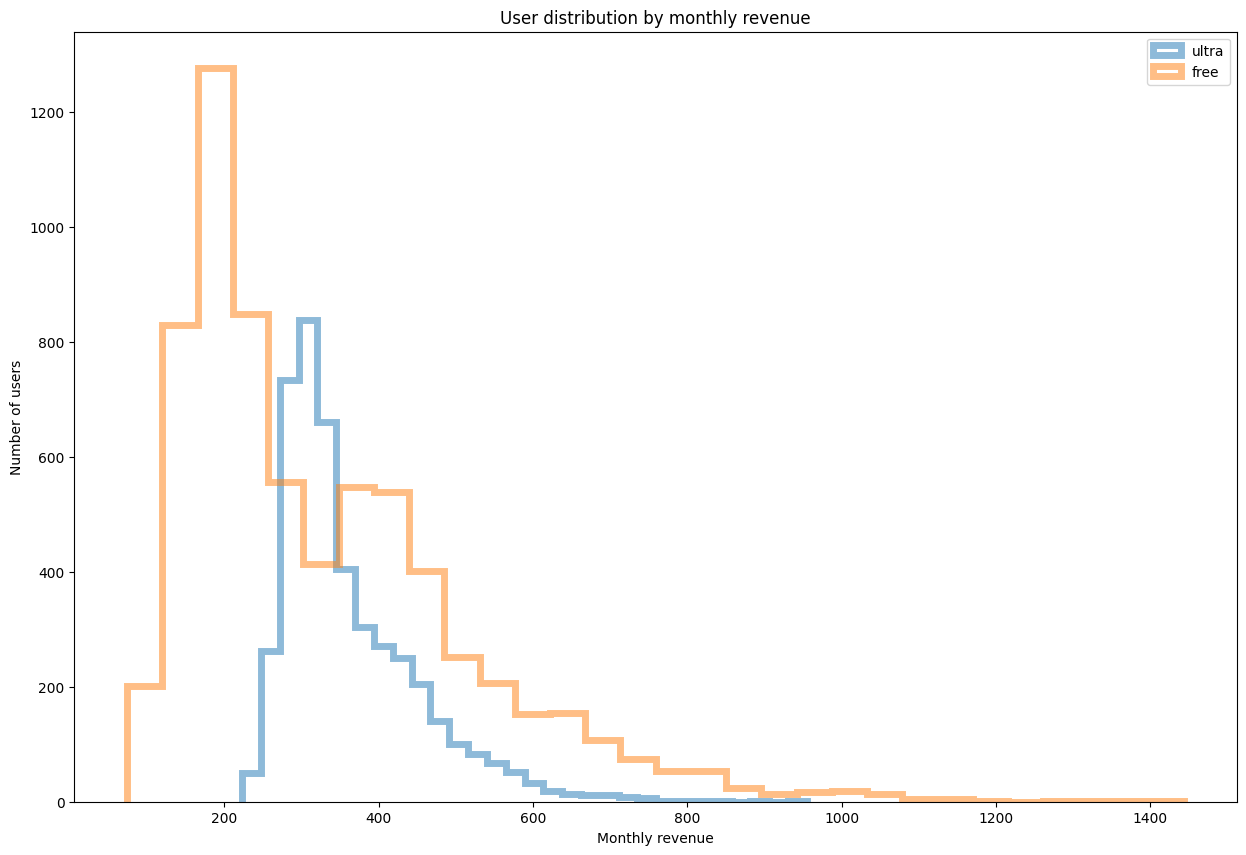

In [180]:
plt.figure(figsize=(15,10))
plt.xlabel('Monthly revenue')
plt.ylabel('Number of users')
plt.title('User distribution by monthly revenue')
plt.hist(
    df_agg.query('subscription_type == "ultra"')['month_revenue'],
    bins=30,
    alpha=0.5,
    label='ultra',
    histtype='step',
    linewidth=5,
)
plt.hist(
    df_agg.query('subscription_type == "free"')['month_revenue'],
    bins=30,
    alpha=0.5,
    label='free',
    histtype='step',
    linewidth=5
)
plt.legend(loc='upper right')
plt.show()

In [181]:
df_agg.query('subscription_type == "ultra"')['month_revenue'].describe()

count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: month_revenue, dtype: float64

In [182]:
df_agg.query('subscription_type == "free"')['month_revenue'].describe()

count    6767.000000
mean      329.332644
std       183.268419
min        74.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: month_revenue, dtype: float64

**The standard deviation differs by more than 2x, but the t-test is robust to such differences, especially with large samples. We'll use the equal variance t-test.**

In [183]:
#df_agg_ultra_sample = df_agg.query('subscription_type == "ultra"')['month_revenue'].sample(n=3000, random_state=1)
#df_agg_free_sample = df_agg.query('subscription_type == "free"')['month_revenue'].sample(n=3000, random_state=1)

In [184]:
alpha = 0.05# set significance level to 5%
results = st.ttest_ind(df_agg.query('subscription_type == "ultra"')['month_revenue'],
                       df_agg.query('subscription_type == "free"')['month_revenue'],
                       alternative='greater') #two-sample t-test for independent samples
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-value: 2.0314113674863288e-30
Reject the null hypothesis


**We reject the null hypothesis in favor of the alternative: the mean monthly revenue from Ultra subscribers is greater than from Free users.**

##### Suppose the technical team updated the servers, hoping that the number of support requests would significantly decrease. A file contains the number of requests per user before and after the update. Which test would you use to check this hypothesis?

**Since we compare data for the same users before and after the update, the samples are dependent. The null hypothesis (H0) is that the mean after and before the update are equal, the alternative is that the mean after is less than before (left-sided). We use the paired t-test: st.ttest_rel(requests_after, requests_before, alternative='less').**

##### Final conclusion

**Project goal: process user, ride, and subscription data and perform statistical analysis and hypothesis testing. The marketing department will use the results for campaigns.**

* During preprocessing: removed exact duplicates from users_df, converted date to datetime, and removed outlier rides with very short duration (<1 min) and long distance, which should be reported to the app team.

* Exploratory data analysis findings:
    * Users are distributed fairly evenly across cities, with the fewest in Moscow and the most in Pyatigorsk
    * There are 8% more users without a paid subscription than with one
    * The app is used by people aged 12 to 43, with a mean and median of about 25 years
    * The ride duration histogram peaks at 18 minutes
* The three dataframes were merged into one by user_id and subscription_type
* Visualization by subscription type showed:
    * The ride distance histogram for both paid and free subscriptions peaks between 2500 and 3500 meters, with more spread for free subscriptions
    * The ride duration histogram peaks at 18 minutes for both types
* A pivot table was created with monthly revenue per user based on their subscription
* Hypothesis testing results for marketing:
    * The mean ride duration for Ultra subscribers is greater than for Free users
    * The mean ride distance per trip for Ultra subscribers does not exceed 3130 meters
    * The mean monthly revenue from Ultra subscribers is greater than from Free users
    
**In summary, subscribers are more profitable for the scooter rental service**

#### Step 7. Distributions

##### The GoFast marketing department wants to run a promo giving out free one-month subscriptions, aiming for at least 100 existing clients to renew. After a previous campaign, 10% renewed. What is the minimum number of promo codes to send so the probability of not meeting the target is about 5%? Choose a distribution, plot it, and answer.

In [185]:
target = 99
p = 0.1
for N in range(target, 10*int(target / p)):
    if st.binom.cdf(target, N, p) <= 0.05:
        print(N)
        break


1161


**Above we got N = 1161, meaning if we send 1161 promo codes, there is a 95% chance at least 100 clients will renew. Let's plot the binomial distribution with these parameters.**

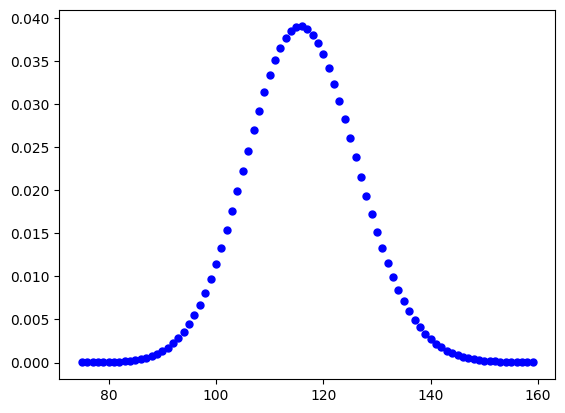

In [186]:
x = list(range(75, 160))
bx = plt.subplot()
bx.plot(x, st.binom.pmf(x, 1161, p), 'bo', ms=5, label='binomial distribution probabilities')
print()


**Answer: send at least 1172 invitations to achieve 100 renewals with a 5% risk of not meeting the target.**

##### The marketing department sends push notifications to clients, who may or may not open them. About 40% open them. If 1 million notifications are sent, use an approximation to plot the distribution and estimate the probability that no more than 399,500 users open it.

In this problem, it's convenient to approximate the binomial distribution with a normal one. The probability of success p is close to 0.5, and n (one million) is large. Let's check the approximation criterion.

In [187]:
p = 0.4
n = 1_000_000
mu = n * p
sigma = sqrt(n * p * (1 - p))
print(round((mu - 3 * sigma), 1), round((mu + 3 * sigma), 1))

398530.3 401469.7


Given the data values fall within the range of [0,1000000], approximating with a normal distribution should be a good choice

Let's calculate the probability of getting a value less than or equal to 399,500, i.e., the left tail. For this, we use the cumulative function.

In [188]:
distr = st.norm(mu, sigma) 

result = distr.cdf(399500)
print(result)

0.15371708296369768



**The probability of getting this value or less: 15.37%**

Let's plot the approximate distribution.

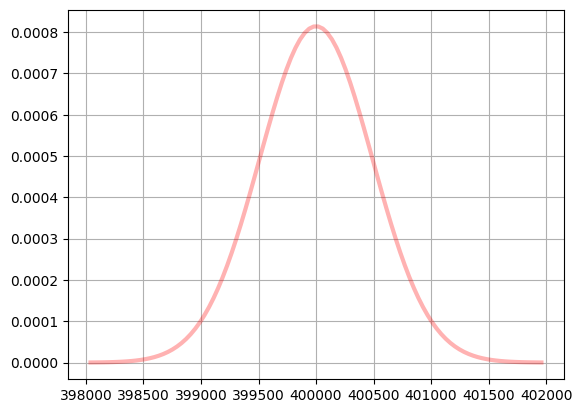

In [189]:
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
x = np.linspace(left, right, 100)
ax = plt.subplot()
ax.plot(x,
        st.norm.pdf(x, mu, sigma),
        'r-', lw=3, alpha=0.3,
       )
plt.grid()